# Preliminary Analysis of OpenStreetMap Data for Yukon Territory

As a first step, we aimed to replicate the work done by [Diego Matos Chavez (2020)](https://medium.com/data-science/estimating-the-population-of-arbitrarily-chosen-areas-533e81c2104e), where OSM data was used to estimate the population of London. The author created a command-line application that performs feature extraction on OpenStreetMap (OSM) data. 

## Data preparation


### OSM Data

First, we will inspect the data downloaded from the [OSM export tool](https://export.hotosm.org/v3/). For a specified area, this tool outputs OSM data in a variety of formats: GeoJSON, GPKG, SHP, and OSM.PBF. 

While the tool also exports a clipping boundary, this is not exactly the territorial boundary. As such, a GeoJSON of the territorial boundary was downloaded from [Open Data Soft](https://data.opendatasoft.com/explore/dataset/georef-canada-province%40public/export/?disjunctive.prov_name_en) and was used to clip the OSM data to the precise territorial boundary. 

In [9]:
# Import packages 

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
import json
import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from population_geojson import process_lines, format_lines, load_and_clean_geojson

In [7]:
# Load geopackage data
gdf = gpd.read_file("Data/OSM_exports/Yukon_gpkg_uid_9cf9d9be-ab7a-413b-8de5-50db2e3aa7f2/Yukon.gpkg")

# Load territorial boundary
with open("Data/georef-canada-province@public.geojson") as f:
    boundary_data = json.load(f)
boundary_poly = shape(boundary_data['features'][0]['geometry'])

# Convert to a GeoDataFrame
boundary_gdf = gpd.GeoDataFrame(index=[0], geometry=[boundary_poly], crs="EPSG:4326")

# Clip the original GeoDataFrame to the boundary
gdf_clipped = gpd.clip(gdf, boundary_gdf)

# Save clipped gdf as geojson
gdf_clipped.to_file("Data/clipped_data/clipped_geojson.geojson", driver="GeoJSON")

# Create smaller gdfs for interactive map
gdf_clipped_points = gdf_clipped[gdf_clipped.geometry.type == "Point"]
gdf_clipped_points.to_file("Data/clipped_data/clipped_points.geojson", driver="GeoJSON")
gdf_clipped_line = gdf_clipped[gdf_clipped.geometry.type == "LineString"]
gdf_clipped_line.to_file("Data/clipped_data/clipped_lines.geojson", driver="GeoJSON")
gdf_clipped_multiline = gdf_clipped[gdf_clipped.geometry.type == "MultiLineString"]
gdf_clipped_multiline.to_file("Data/clipped_data/clipped_multilines.geojson", driver="GeoJSON")
gdf_clipped_poly = gdf_clipped[gdf_clipped.geometry.type == "Polygon"]
gdf_clipped_poly.to_file("Data/clipped_data/clipped_multipoly.geojson", driver="GeoJSON")
gdf_clipped_multipoly = gdf_clipped[gdf_clipped.geometry.type == "MultiPolygon"]
gdf_clipped_multipoly.to_file("Data/clipped_data/clipped_multipoly.geojson", driver="GeoJSON")
gdf_clipped_buildings = gdf_clipped[gdf_clipped["building"].notnull()]
gdf_clipped_buildings.to_file("Data/clipped_data/clipped_buildings.geojson", driver="GeoJSON")

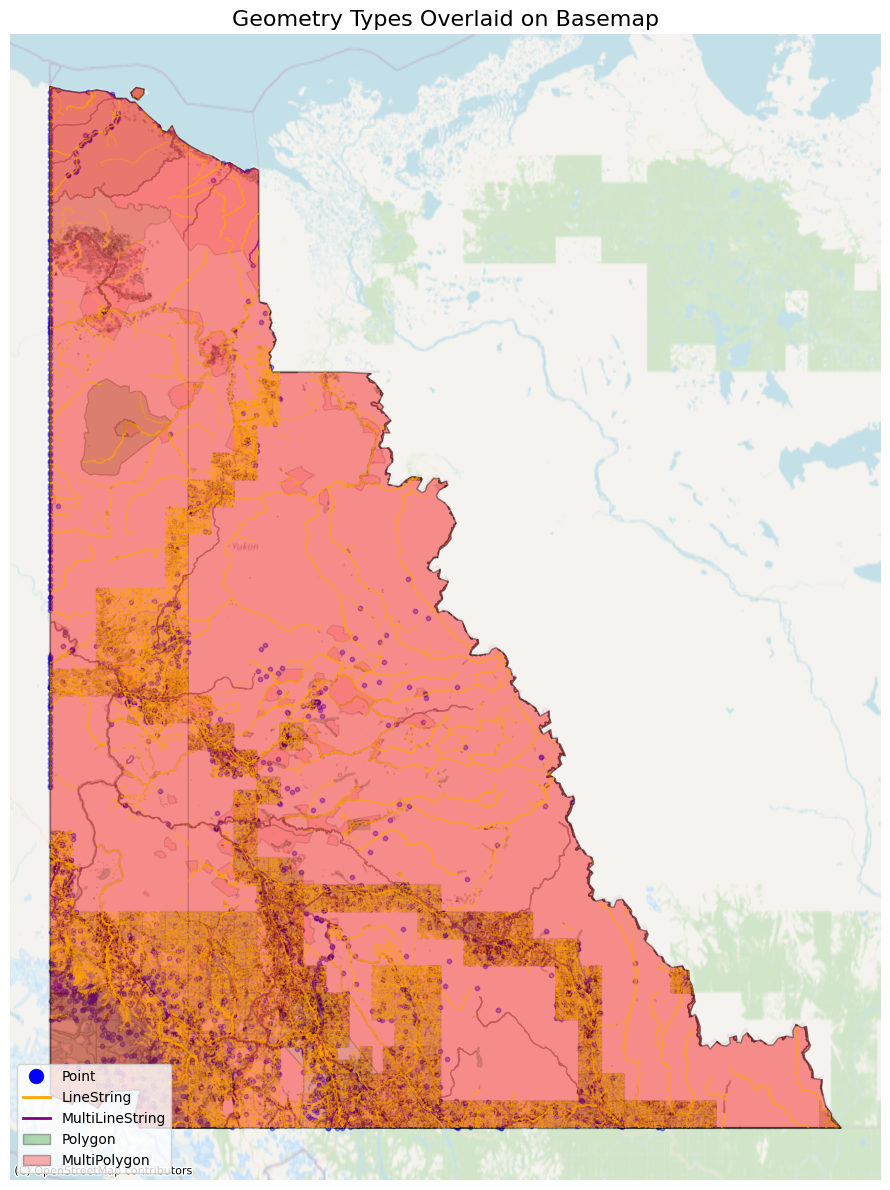

In [3]:
# Plot different geometries with different colors

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot geometries with transparency
gdf_clipped[gdf_clipped.geometry.type == 'Point'].plot(ax=ax, color='blue', markersize=10, alpha=0.4)
gdf_clipped[gdf_clipped.geometry.type == 'LineString'].plot(ax=ax, color='orange', linewidth=1, alpha=0.4)
gdf_clipped[gdf_clipped.geometry.type == 'MultiLineString'].plot(ax=ax, color='purple', linewidth=1, alpha=0.4)
gdf_clipped[gdf_clipped.geometry.type == 'Polygon'].plot(ax=ax, facecolor='green', edgecolor='black', alpha=0.1)
gdf_clipped[gdf_clipped.geometry.type == 'MultiPolygon'].plot(ax=ax, facecolor='red', edgecolor='black', alpha=0.1)

# Add basemap
ctx.add_basemap(ax, crs=gdf_clipped.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.7)

# Build custom legend
legend_handles = [
    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='Point'),
    mlines.Line2D([], [], color='orange', linewidth=2, label='LineString'),
    mlines.Line2D([], [], color='purple', linewidth=2, label='MultiLineString'),
    mpatches.Patch(facecolor='green', edgecolor='black', alpha=0.3, label='Polygon'),
    mpatches.Patch(facecolor='red', edgecolor='black', alpha=0.3, label='MultiPolygon')
]

ax.legend(handles=legend_handles, loc='lower left')
ax.set_title("Geometry Types Overlaid on Basemap", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.show()

OSM defines data using three basic elements: nodes, ways, and relations. A **node** represents single location, defined by coordinates. Nodes often represent standalone features, like a water fountain or a tree. A **way** is a series of connected nodes. If a way is comprised of an unenclosed series of nodes, it can be used to represent linear features like roads or rivers. If the series of nodes is enclosed, it forms a **closed way** which represents the boundary of an area. Closed ways denote features like buildings or parks. Finally, **relations** define a relationship between two or more elements (nodes, ways, or other relations). Relations may include a collection of ways that form a bus route, or some area with an outer boundary but holes in the middle. 

OSM data structures are in line with traditional GIS data. Nodes are equivalent to **points**, and unenclosed ways are similar to **linestrings** and **multi-line strings**. Enclosed ways defining an area are represented as **polygons**, whereas areas with holes are represented as **multipolygons**. A table defining the relationships can be found below. 

| GIS | OSM | Example from Yukon Data |
| --- | --- | --- |
| Point | Node | Ottawa Glacier |
| LineString | Unenclosed Way | Spring Creek |
| MultiLineString | Unenclosed Way | Service highway |
| Polygon | Closed Way | Donjek Lakes |
| MultiPolygon | Relation | Stikine Region |


### Merging Population Counts with Geospatial Data

The `osm-feature-extractor` command-line application requires a GeoJSON with sub-divided areas and their known populations. Therefore, the next step of the analysis was to create a file meeting these specifications.  


Population counts for the census subdivisions from 2019-2022 are contained in a [PDF](https://yukon.ca/sites/default/files/ybs/fin-population-estimates-census-subdivision-2019-to-2022.pdf) on the Yukon.ca official website. A csv was created to store this information in a more usable format. Data from 2021 was used, as this was the last federal census. 

In [36]:
# Scrape data from PDF
pdf_path = "Data/fin-population-estimates-census-subdivision-2019-to-2022.pdf"
lines = process_lines(pdf_path)
pop_df = format_lines(lines)

# Save to CSV
pop_df.to_csv("Data/yukon_population_estimates_cleaned.csv", index=False)

# Save 2022 data
pop_2021 = pop_df[["Subdivision", "2021"]].copy()
pop_2021.rename(columns={"2021":"population"}, inplace=True)
pop_2021 = pop_2021[pop_2021["Subdivision"] != "Yukon"]


Then, a GeoJSON of the census subdivisions was downloaded, again from [Open Data Soft](https://public.opendatasoft.com/explore/dataset/georef-canada-census-subdivision/table/?disjunctive.prov_name_en&disjunctive.cd_name_en&disjunctive.csd_name_en&refine.prov_name_en=Yukon). 

In [41]:
# Load census subdivisions GEOJSON
sub_gdf = load_and_clean_geojson("Data/georef-canada-census-subdivision@public.geojson")

# Load territorial boundary, for mapping
territorial_boundary = gpd.read_file("Data/georef-canada-province@public.geojson")


Skipping field prov_code: unsupported OGR type: 5
Skipping field prov_name_en: unsupported OGR type: 5


Finally, the spatial data was merged with the population data. 

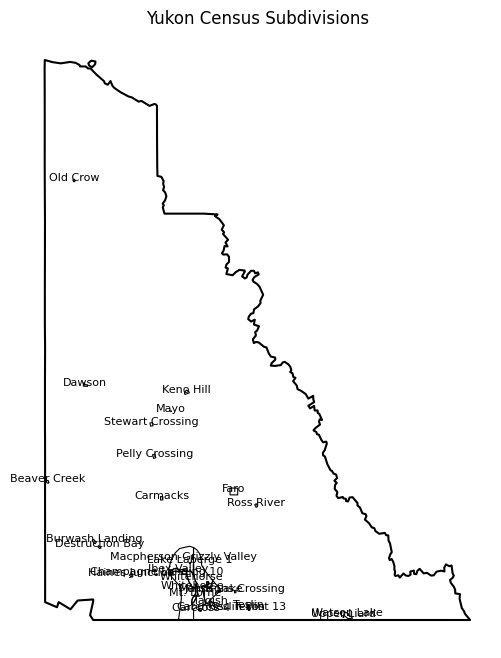

In [43]:
# Add 2021 population to subdivision geojson

# Create a version that has all subdivisions, even those missing population data. 
# Perhaps later on we can predict populations in these areas. 
merged_total = sub_gdf.merge(pop_2021, how="left", left_on="csd_name_en", right_on="Subdivision")

# For modelling, create a version with no missing data using an inner join. 
merged_inner = sub_gdf.merge(pop_2021, how="inner", left_on="csd_name_en", right_on="Subdivision")


# Plot just the subdivisions
fig, ax = plt.subplots(figsize=(12, 8))
merged_inner.plot(
    edgecolor="black",       # Outline all subdivisions
    facecolor="none",        # No fill color
    linewidth=0.8,           # Adjust border thickness
    ax=ax
)
# Plot the territorial boundary
territorial_boundary.plot(
    edgecolor="black",         # Outline the boundary in red
    facecolor="none",        # No fill color
    linewidth=1.5,           # Adjust border thickness
    ax=ax
)

# Add subdivision names as labels
for idx, row in merged_inner.iterrows():
    # Use the centroid of each geometry for label placement
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, 
        row["Subdivision"],     # Replace with the column containing subdivision names
        fontsize=8, 
        ha="center"
    )

plt.title("Yukon Census Subdivisions")
plt.axis("off")
plt.show()


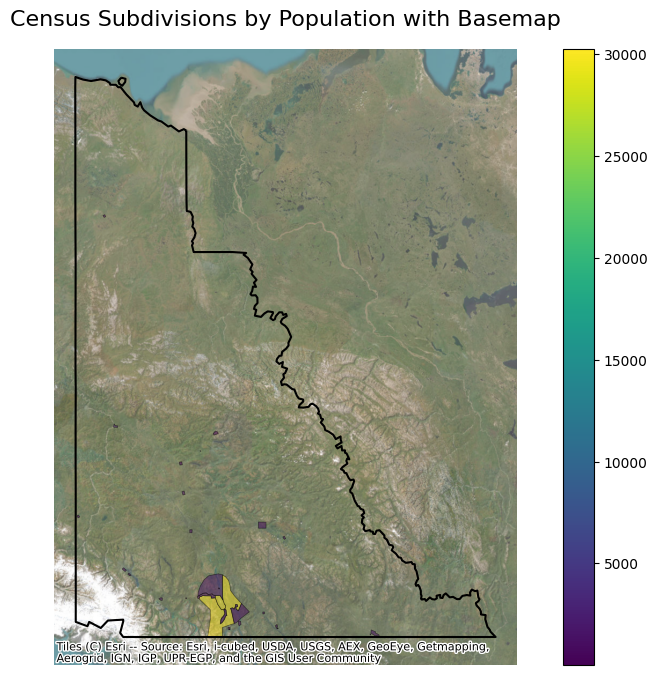

In [49]:
# Plot the census subdivisions
merged_web_mercator = merged_inner.to_crs(epsg=3857)
territorial_boundary_proj = territorial_boundary.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(12, 8))
merged_web_mercator.plot(
    column="population",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.5,                        # Transparency for all polygons
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "No data"
    }
)

# Plot the territorial boundary
territorial_boundary_proj.plot(
    edgecolor="black",         # Outline the boundary in red
    facecolor="none",        # No fill color
    linewidth=1.5,           # Adjust border thickness
    ax=ax
)

# Add a basemap 
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, alpha=0.7)

# Add title and remove axes
plt.title("Census Subdivisions by Population with Basemap", fontsize=16)
plt.axis("off")

plt.show()

In [ ]:
# Save data
merged_total.to_file("Data/sub_population_full.geojson", driver="GeoJSON")
merged_inner.to_file("Data/sub_population_inner.geojson", driver="GeoJSON")